In [1]:
import pandas as pd
import numpy as np
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as rng
import re
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

caminho_do_projeto = r'C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao'

if caminho_do_projeto not in sys.path:
    sys.path.insert(0, caminho_do_projeto)
from projeto_aplicado.modelos.otimizador_pli import OtimizadorPLI
from projeto_aplicado.modelos.otimizador_aco import OtimizadorACO
from projeto_aplicado.modelos.otimizador_ag import OtimizadorAG
from projeto_aplicado.modelos.otimizador_base import Otimizador
from projeto_aplicado.modelos.analisador import AnalisadorDeSolucao
base = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\dados"
grafs_dir = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\graficos"

# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

cor1 = "#006064"
cor2 = "#D35400"
cores = ['#006064', '#D35400', '#2E86C1', '#884EA0', '#28B463', '#7F8C8D']
l1 = ["#E0F7FA","#006064" ]
l2 = ["#D35400", "#006064"]
gradiente = LinearSegmentedColormap.from_list("meu_gradiente", l2)

In [2]:
lhs = pd.read_csv('novo_lhs_simulacoes.csv')
df = pd.DataFrame()
for arq in os.listdir('resultados_batches_v4/'):
    if 'resultados' in arq:
        result = pd.read_csv(f'resultados_batches_v4/{arq}')
        df = pd.concat([df, result], ignore_index=True)
df.sort_values('simulacao', inplace=True)
df_resumo = df[['simulacao','tempo_aco', 'geracoes_aco', 'geracao_convergencia_aco']].copy()
df_pli = df['resultado_pli'].apply(eval).str[0].apply(pd.Series)[['escore_total']].rename(columns={'escore_total':'escore_pli'})
df_aco = df['resultado_aco'].apply(eval).str[0].apply(pd.Series)[['escore_total']].rename(columns={'escore_total':'escore_aco'})
df_resumo = pd.concat([df_resumo, df_pli, df_aco], axis=1)
df_resumo = df_resumo.merge(lhs[['simulacao', 'n_formigas', 'alfa', 'beta', 'taxa_evaporacao']], on='simulacao')

df_resumo['tempo_medio_por_geracao'] = df_resumo['tempo_aco'] / 150
df_resumo['fit_max'] = df_resumo['escore_pli'] <= df_resumo['escore_aco']
df_resumo['tempo_ate_convergencia'] = df_resumo['tempo_medio_por_geracao'] * (df_resumo['geracao_convergencia_aco'] )
df_resumo['pontuacao_relativa'] = (df_resumo['escore_aco'] / df_resumo['escore_pli']).apply(lambda x: min(x, 1.0))

#df_resumo = df_resumo.sample(100)


In [11]:
d1 = pd.DataFrame(df_resumo['geracao_convergencia_aco'].value_counts(normalize=True)).reset_index().sort_values('geracao_convergencia_aco')
d1['freq_acumulada'] = d1['proportion'].cumsum()


d1

,geracao_convergencia_aco,proportion,freq_acumulada
7,1,0.032,0.032
1,2,0.139,0.171
0,3,0.190,0.361
2,4,0.137,0.498
3,5,0.083,0.581
4,6,0.064,0.645
5,7,0.057,0.702
6,8,0.042,0.744
8,9,0.032,0.776
9,10,0.026,0.802


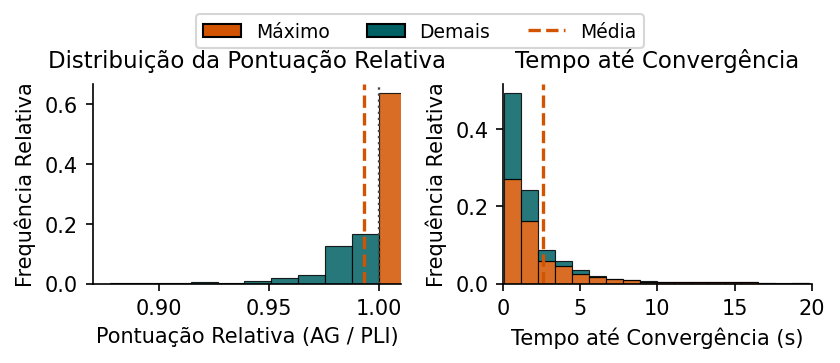

In [129]:
plt.style.use("default")
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(5.7, 2.3), dpi=150)

# --- Esquerda: histograma da pontuação relativa (frequência relativa) ---
vals_sem_1 = df_resumo[df_resumo['pontuacao_relativa'] < 1]['pontuacao_relativa']
num_1 = len(df_resumo[df_resumo['pontuacao_relativa'] == 1])
n_bins_calc = 10

bins = np.linspace(vals_sem_1.min(), 1.0, n_bins_calc + 1)
largura_bin = bins[1] - bins[0]

weights_sem_1 = np.ones_like(vals_sem_1, dtype=float) / len(df_resumo)
weight_ones   = num_1 / len(df_resumo)

ax_left.hist(vals_sem_1, bins=bins, weights=weights_sem_1,
             color=cor1, edgecolor="black", linewidth=0.55, alpha=0.85)
ax_left.bar(1.0, weight_ones, width=largura_bin, align='edge',
            color=cor2, edgecolor="black", linewidth=0.55, alpha=0.85)

media_pr = df_resumo['pontuacao_relativa'].mean()
ax_left.axvline(media_pr, color=cor2, lw=1.6, linestyle="--")
ax_left.axvline(1.0, color="#444444", lw=1.1, linestyle=":")

ax_left.set_title("Distribuição da Pontuação Relativa", fontsize=11, pad=8)
ax_left.set_xlabel("Pontuação Relativa (AG / PLI)", fontsize=10)
ax_left.set_ylabel("Frequência Relativa", fontsize=10)
ax_left.set_xlim(0.87, 1.01)
ax_left.set_facecolor("white")
for s in ['top','right']:
    ax_left.spines[s].set_visible(False)
ax_left.grid(False)

# --- Direita: histograma empilhado do tempo até convergência (frequência relativa; convergidos por baixo) ---
mask_max = df_resumo[df_resumo['tempo_ate_convergencia'] < 20]['fit_max']
tempos_convergiu = df_resumo.loc[(df_resumo['tempo_ate_convergencia'] < 20) & mask_max, 'tempo_ate_convergencia']
tempos_nao       = df_resumo.loc[(df_resumo['tempo_ate_convergencia'] < 20) & (~mask_max), 'tempo_ate_convergencia']

n_bins_tempo = 50
tempo_min = df_resumo['tempo_ate_convergencia'].min()
tempo_max = df_resumo['tempo_ate_convergencia'].max()
bins_tempo = np.linspace(tempo_min, tempo_max, n_bins_tempo + 1)

weights_convergiu = np.ones(len(tempos_convergiu), dtype=float) / len(df_resumo)
weights_nao       = np.ones(len(tempos_nao), dtype=float) / len(df_resumo)

ax_right.hist([tempos_convergiu, tempos_nao],
              bins=bins_tempo,
              weights=[weights_convergiu, weights_nao],
              stacked=True,
              color=[cor2, cor1],
              edgecolor="black",
              linewidth=0.55,
              alpha=0.85)

media_tempo = df_resumo['tempo_ate_convergencia'].mean()
ax_right.axvline(media_tempo, color=cor2, lw=1.6, linestyle="--")
ax_right.set_xlim(0, 20)
ax_right.set_title("Tempo até Convergência", fontsize=11, pad=8)
ax_right.set_xlabel("Tempo até Convergência (s)", fontsize=10)
ax_right.set_ylabel("Frequência Relativa", fontsize=10)
ax_right.set_facecolor("white")
for s in ['top','right']:
    ax_right.spines[s].set_visible(False)
ax_right.grid(False)

# Legenda única acima
legend_handles = [
    Patch(facecolor=cor2, edgecolor='black', label='Máximo'),
    Patch(facecolor=cor1, edgecolor='black', label='Demais'),
    Line2D([0], [0], color=cor2, lw=1.6, linestyle="--", label=f"Média"),
]
fig.legend(handles=legend_handles, loc='upper center', ncol=4, frameon=True,
           fontsize=9, bbox_to_anchor=(0.5, 1.06))

plt.tight_layout()
plt.savefig("../graficos/aco_duplo_hist_pontuacao_e_tempo_convergencia_freq_relativa.pdf",
            format="pdf", bbox_inches="tight")
plt.show()

In [130]:
df_resumo['pontuacao_relativa'].quantile([.1,.15,.2, 0.25, 0.5, 0.75])

0.10    0.978556
0.15    0.985294
0.20    0.992424
0.25    0.992647
0.50    1.000000
0.75    1.000000
Name: pontuacao_relativa, dtype: float64

In [139]:
df_resumo[df_resumo['tempo_ate_convergencia'] > 10].reset_index()

,index,simulacao,tempo_aco,geracoes_aco,geracao_convergencia_aco,escore_pli,escore_aco,n_formigas,alfa,beta,taxa_evaporacao,tempo_medio_por_geracao,fit_max,tempo_ate_convergencia,pontuacao_relativa
0,13,14.0,18.078125,150,132,140,137,20,0.131042,2.352654,0.223709,0.120521,False,15.908750,0.978571
1,53,54.0,58.421875,150,36,136,136,72,0.693860,1.407561,0.187154,0.389479,True,14.021250,1.000000
2,61,62.0,56.187500,150,141,135,135,72,0.218248,7.942572,0.039257,0.374583,True,52.816250,1.000000
3,88,89.0,68.265625,150,25,136,136,85,1.880795,3.452806,0.021492,0.455104,True,11.377604,1.000000
4,191,192.0,43.015625,150,107,135,134,65,0.295955,3.032305,0.057182,0.286771,False,30.684479,0.992593
5,203,204.0,68.234375,150,90,140,140,85,0.234335,5.885858,0.013601,0.454896,True,40.940625,1.000000
6,233,234.0,19.671875,150,125,139,139,24,0.321676,6.735049,0.185698,0.131146,True,16.393229,1.000000
7,290,291.0,67.328125,150,27,139,138,83,3.272004,3.665592,0.048841,0.448854,False,12.119063,0.992806
8,308,309.0,66.687500,150,104,139,136,94,0.121170,1.646073,0.256561,0.444583,False,46.236667,0.978417
9,318,319.0,84.796875,150,24,136,136,93,0.641035,1.493848,0.239911,0.565312,True,13.567500,1.000000


In [132]:
df_resumo['fit_max'].value_counts()

fit_max
True     636
False    364
Name: count, dtype: int64

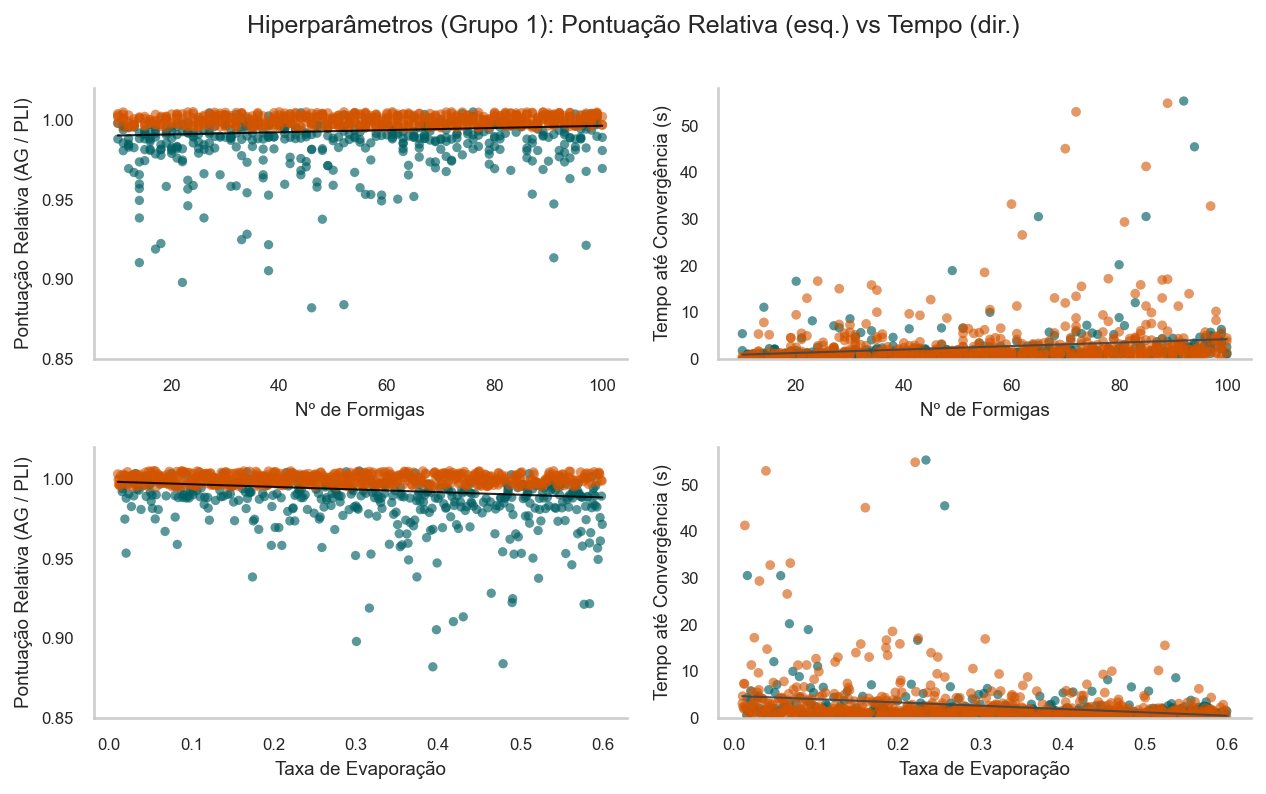

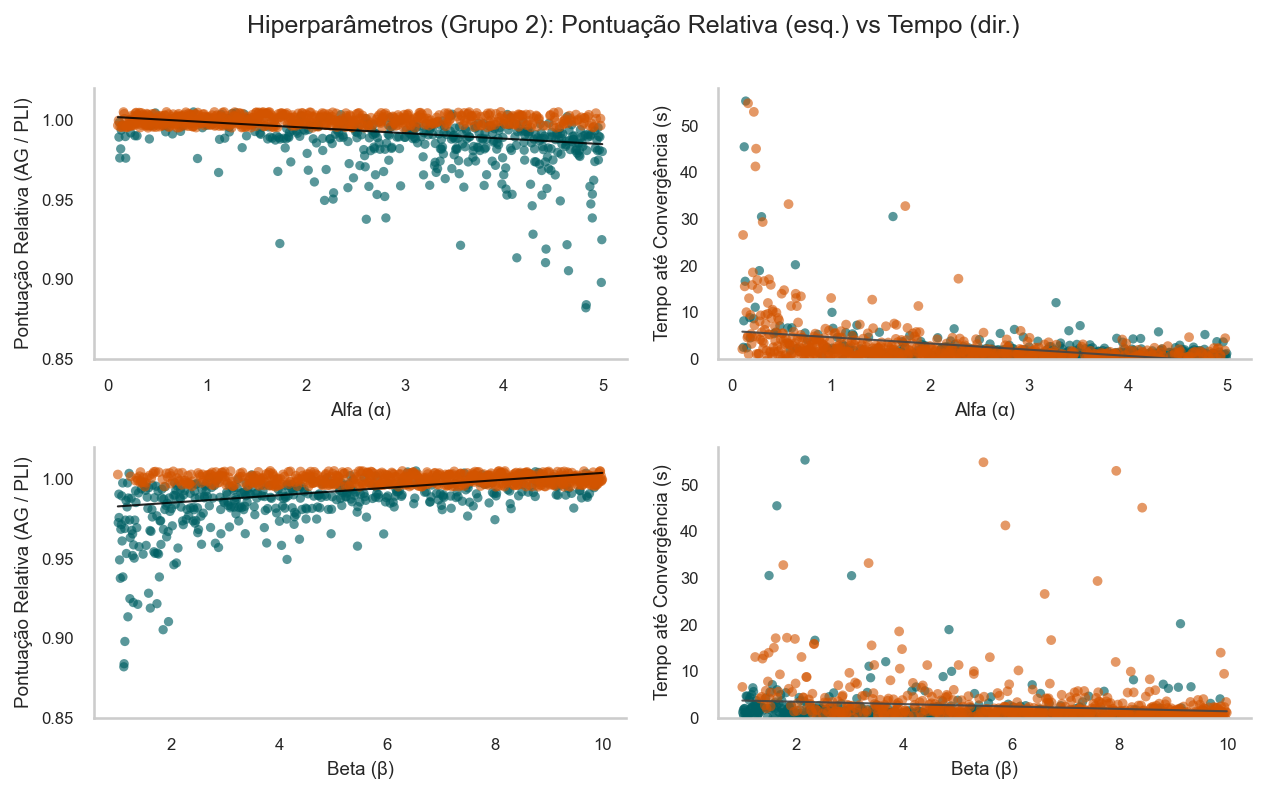

In [108]:
# ...existing code...
# === CONTROLES DE PLOT (ajuste aqui) ===
plot_cfg = {
    "sizes":      {"sucesso": 22, "falha": 20},
    "alphas":     {"sucesso": 0.6, "falha": .65},
    "edgecolors": {"sucesso": "none", "falha": "none"},   # use 'black' ou '#333' se quiser borda
    "edgewidth":  0.6,                                    # linewidth da borda
    "jitter": {
        "x_amplitude_small": 0.25,   # jitter horizontal se poucas categorias únicas
        "y_rel": 0.005,              # amplitude do jitter vertical para pontuação_relativa
        "y_tempo_factor": 0.015      # fator * range do tempo para jitter vertical
    },
    "seed": 42
}

pares_figuras = [
    ["n_formigas", "taxa_evaporacao"],
    ["alfa", "beta"]
]

x_labels = {
    "n_formigas": "Nº de Formigas",
    "alfa": "Alfa (α)",
    "beta": "Beta (β)",
    "taxa_evaporacao": "Taxa de Evaporação"
}

rng = np.random.default_rng(plot_cfg["seed"])
mask_sucesso = df_resumo["fit_max"]
y_rel = df_resumo["pontuacao_relativa"].astype(float)
tempo_raw = df_resumo["tempo_ate_convergencia"].astype(float)

y_min = max(0.85, y_rel.min() - 0.01)
y_max = 1.02

# Jitter vertical
y_rel_jitter = y_rel + rng.uniform(-plot_cfg["jitter"]["y_rel"],
                                   plot_cfg["jitter"]["y_rel"],
                                   size=len(y_rel))
tempo_range = max(1e-9, tempo_raw.max() - tempo_raw.min())
tempo_jitter = tempo_raw + rng.uniform(-plot_cfg["jitter"]["y_tempo_factor"] * tempo_range,
                                       plot_cfg["jitter"]["y_tempo_factor"] * tempo_range,
                                       size=len(tempo_raw))

def jitter_x(series: pd.Series) -> np.ndarray:
    s = series.astype(float).copy()
    if s.nunique() <= 15:
        amp = plot_cfg["jitter"]["x_amplitude_small"]
        s += rng.uniform(-amp, amp, size=len(s))
    return s

for grupo_idx, grupo in enumerate(pares_figuras, start=1):
    n_rows = len(grupo)
    fig, axes = plt.subplots(n_rows, 2, figsize=(8.6, 2.65 * n_rows), dpi=150)
    if n_rows == 1:
        axes = np.array([axes])

    for i, hp in enumerate(grupo):
        ax_left  = axes[i, 0]
        ax_right = axes[i, 1]

        x_vals = df_resumo[hp].astype(float)
        x_plot_l = jitter_x(x_vals)
        x_plot_r = x_plot_l  # mesmo jitter horizontal

        # --- ESQUERDA: Pontuação Relativa ---
        ax_left.scatter(
            x_plot_l[~mask_sucesso], y_rel_jitter[~mask_sucesso],
            s=plot_cfg["sizes"]["falha"],
            facecolor=cor1,
            edgecolor=plot_cfg["edgecolors"]["falha"],
            linewidth=plot_cfg["edgewidth"],
            alpha=plot_cfg["alphas"]["falha"]
        )
        ax_left.scatter(
            x_plot_l[mask_sucesso], y_rel_jitter[mask_sucesso],
            s=plot_cfg["sizes"]["sucesso"],
            facecolor=cor2,
            edgecolor=plot_cfg["edgecolors"]["sucesso"],
            linewidth=plot_cfg["edgewidth"],
            alpha=plot_cfg["alphas"]["sucesso"]
        )

        if x_vals.nunique() > 1:
            try:
                a, b = np.polyfit(x_vals, y_rel, 1)
                xx_line = np.linspace(x_vals.min(), x_vals.max(), 150)
                ax_left.plot(xx_line, a * xx_line + b, color="#000000", lw=1.0, alpha=0.85)
            except Exception:
                pass

        ax_left.set_xlabel(x_labels.get(hp, hp), fontsize=9)
        ax_left.set_ylabel("Pontuação Relativa (AG / PLI)", fontsize=9)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_yticks([0.85, 0.9, 0.95, 1.0])
        ax_left.tick_params(axis="both", labelsize=8)
        ax_left.set_facecolor("white")
        for s in ["top", "right"]:
            ax_left.spines[s].set_visible(False)
        ax_left.grid(False)

        # --- DIREITA: Tempo até Convergência ---
        ax_right.scatter(
            x_plot_r[~mask_sucesso], tempo_jitter[~mask_sucesso],
            s=plot_cfg["sizes"]["falha"],
            facecolor=cor1,
            edgecolor=plot_cfg["edgecolors"]["falha"],
            linewidth=plot_cfg["edgewidth"],
            alpha=plot_cfg["alphas"]["falha"]
        )
        ax_right.scatter(
            x_plot_r[mask_sucesso], tempo_jitter[mask_sucesso],
            s=plot_cfg["sizes"]["sucesso"],
            facecolor=cor2,
            edgecolor=plot_cfg["edgecolors"]["sucesso"],
            linewidth=plot_cfg["edgewidth"],
            alpha=plot_cfg["alphas"]["sucesso"]
        )

        if x_vals.nunique() > 1:
            try:
                a_t, b_t = np.polyfit(x_vals, tempo_raw, 1)
                xx_line = np.linspace(x_vals.min(), x_vals.max(), 150)
                ax_right.plot(xx_line, a_t * xx_line + b_t, color="#444444", lw=1.0, alpha=0.9)
            except Exception:
                pass

        ax_right.set_xlabel(x_labels.get(hp, hp), fontsize=9)
        ax_right.set_ylabel("Tempo até Convergência (s)", fontsize=9)
        ax_right.tick_params(axis="both", labelsize=8)
        ax_right.set_facecolor("white")
        ax_right.set_ylim(bottom=0)
        for s in ["top", "right"]:
            ax_right.spines[s].set_visible(False)
        ax_right.grid(False)

    fig.suptitle(f"Hiperparâmetros (Grupo {grupo_idx}): Pontuação Relativa (esq.) vs Tempo (dir.)",
                 fontsize=12, y=0.995)
    plt.tight_layout()
    plt.savefig(f"../graficos/aco_hipers_configuraveis_grupo_{grupo_idx}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

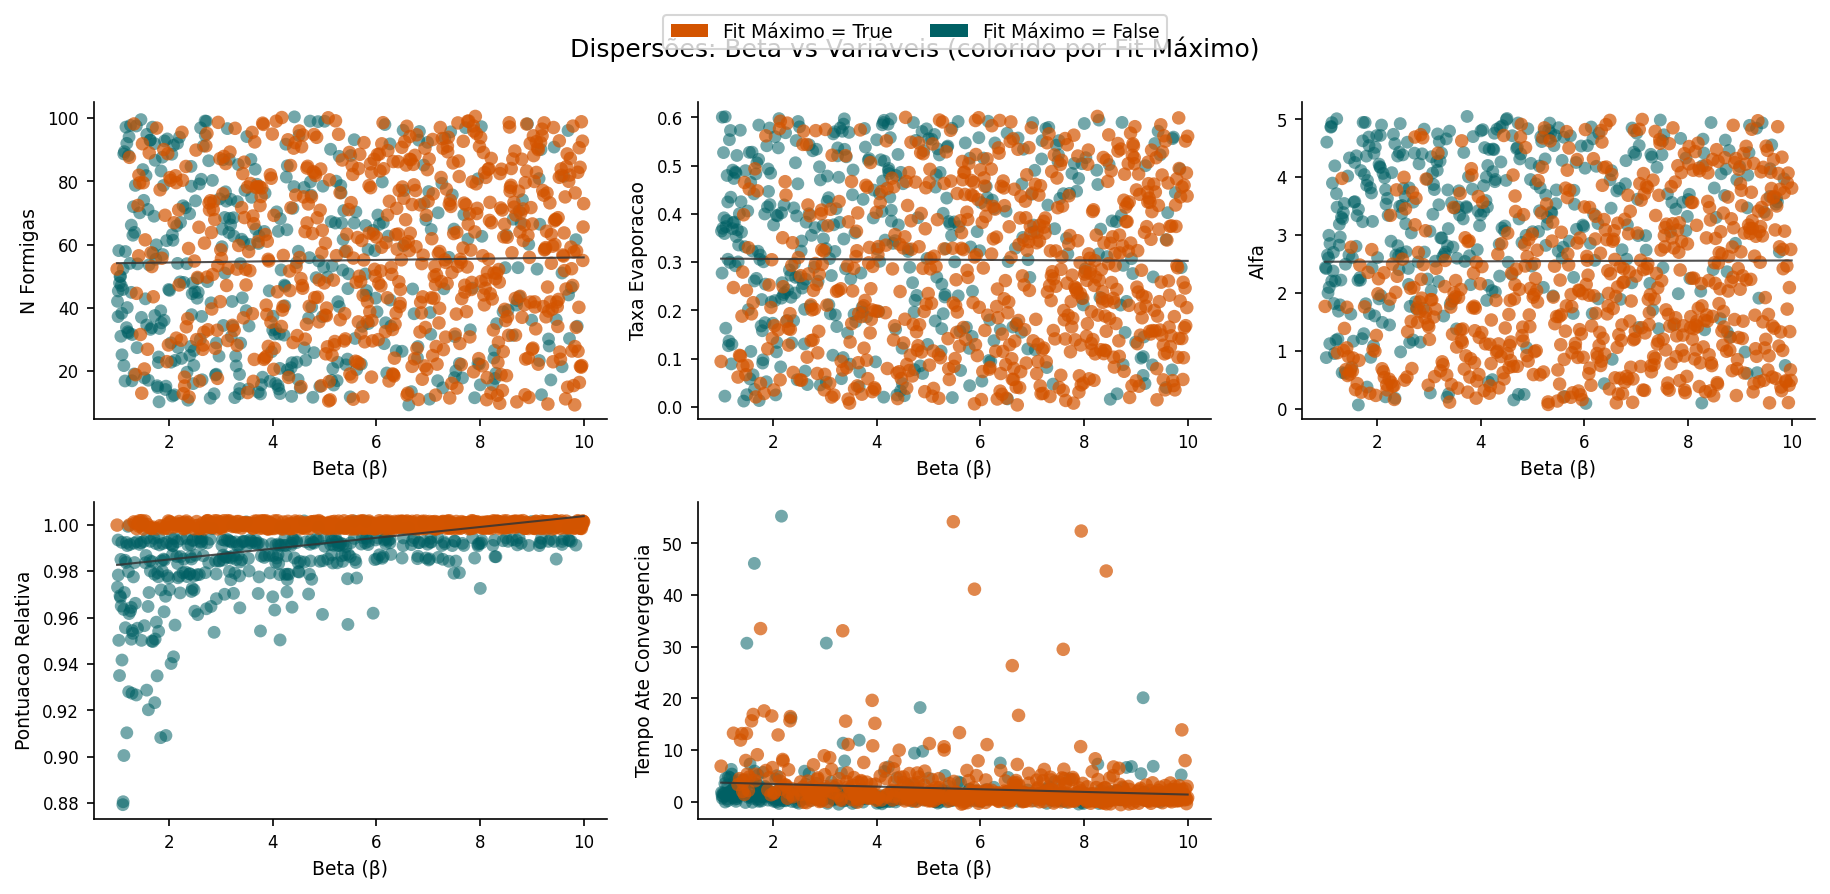

In [92]:
# ...existing code...
# === CONTROLES PARA DISPERSÕES BETA vs VARIÁVEIS ===
scatter_cfg = {
    "size": {"sucesso": 42, "falha": 38},
    "alpha": {"sucesso": 0.70, "falha": 0.55},
    "edgecolor": {"sucesso": "none", "falha": "none"},   # ex.: '#222' para borda
    "edgewidth": 0.6,
    "jitter": {
        "y_factor": 0.015,     # fração do range da variável para jitter vertical
        "x_factor": 0.000      # fração do range do beta (0 = sem jitter horizontal)
    },
    "seed": 202
}

rng_beta = np.random.default_rng(scatter_cfg["seed"])

# Variáveis para eixo Y (beta estará sempre no eixo X)
vars_y = [
    "n_formigas",
    "taxa_evaporacao",
    "alfa",
    "pontuacao_relativa",
    "tempo_ate_convergencia"
]

# Filtra apenas colunas existentes
vars_y = [v for v in vars_y if v in df_resumo.columns]

beta_vals = df_resumo["beta"].astype(float)
mask_fit = df_resumo["fit_max"]

def apply_jitter(x: np.ndarray, y: np.ndarray, y_factor: float, x_factor: float):
    x_range = max(1e-12, x.max() - x.min())
    y_range = max(1e-12, y.max() - y.min())
    x_j = x + rng_beta.uniform(-x_factor * x_range, x_factor * x_range, size=len(x))
    y_j = y + rng_beta.uniform(-y_factor * y_range, y_factor * y_range, size=len(y))
    return x_j, y_j

n_plots = len(vars_y)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.1 * n_cols, 2.9 * n_rows), dpi=150)
axes = np.array(axes).reshape(n_rows, n_cols)

for idx, var in enumerate(vars_y):
    r = idx // n_cols
    c = idx % n_cols
    ax = axes[r, c]

    y_vals = df_resumo[var].astype(float)
    x_plot, y_plot = apply_jitter(beta_vals.to_numpy(),
                                  y_vals.to_numpy(),
                                  scatter_cfg["jitter"]["y_factor"],
                                  scatter_cfg["jitter"]["x_factor"])

    # Dispersão (falha)
    ax.scatter(
        x_plot[~mask_fit],
        y_plot[~mask_fit],
        s=scatter_cfg["size"]["falha"],
        facecolor=cor1,
        edgecolor=scatter_cfg["edgecolor"]["falha"],
        linewidth=scatter_cfg["edgewidth"],
        alpha=scatter_cfg["alpha"]["falha"]
    )
    # Dispersão (sucesso)
    ax.scatter(
        x_plot[mask_fit],
        y_plot[mask_fit],
        s=scatter_cfg["size"]["sucesso"],
        facecolor=cor2,
        edgecolor=scatter_cfg["edgecolor"]["sucesso"],
        linewidth=scatter_cfg["edgewidth"],
        alpha=scatter_cfg["alpha"]["sucesso"]
    )

    # Ajuste linear simples (opcional)
    if beta_vals.nunique() > 1 and y_vals.nunique() > 1:
        try:
            a_lin, b_lin = np.polyfit(beta_vals, y_vals, 1)
            xx_line = np.linspace(beta_vals.min(), beta_vals.max(), 150)
            ax.plot(xx_line, a_lin * xx_line + b_lin, color="#333333", lw=1.0, alpha=0.85)
        except Exception:
            pass

    ax.set_xlabel("Beta (β)", fontsize=9)
    ax.set_ylabel(var.replace("_", " ").title(), fontsize=9)
    ax.tick_params(axis="both", labelsize=8)
    ax.set_facecolor("white")
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.grid(False)

# Remove eixos vazios
for j in range(n_plots, n_rows * n_cols):
    r = j // n_cols
    c = j % n_cols
    axes[r, c].set_visible(False)

# Legenda única
from matplotlib.patches import Patch
leg_handles = [
    Patch(facecolor=cor2, edgecolor='none', label='Fit Máximo = True'),
    Patch(facecolor=cor1, edgecolor='none', label='Fit Máximo = False')
]
fig.legend(handles=leg_handles, loc="upper center", ncol=2, frameon=True, fontsize=9, bbox_to_anchor=(0.5, 1.03))

fig.suptitle("Dispersões: Beta vs Variáveis (colorido por Fit Máximo)", fontsize=12, y=0.995)
plt.tight_layout()
# plt.savefig("../graficos/aco_scatter_beta_vs_variaveis.pdf", format="pdf", bbox_inches="tight")
plt.show()
# ...existing code...

C:\Users\kmenezes\AppData\Local\Temp\ipykernel_32260\1928441826.py:16: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_rel = df_hm.pivot_table(


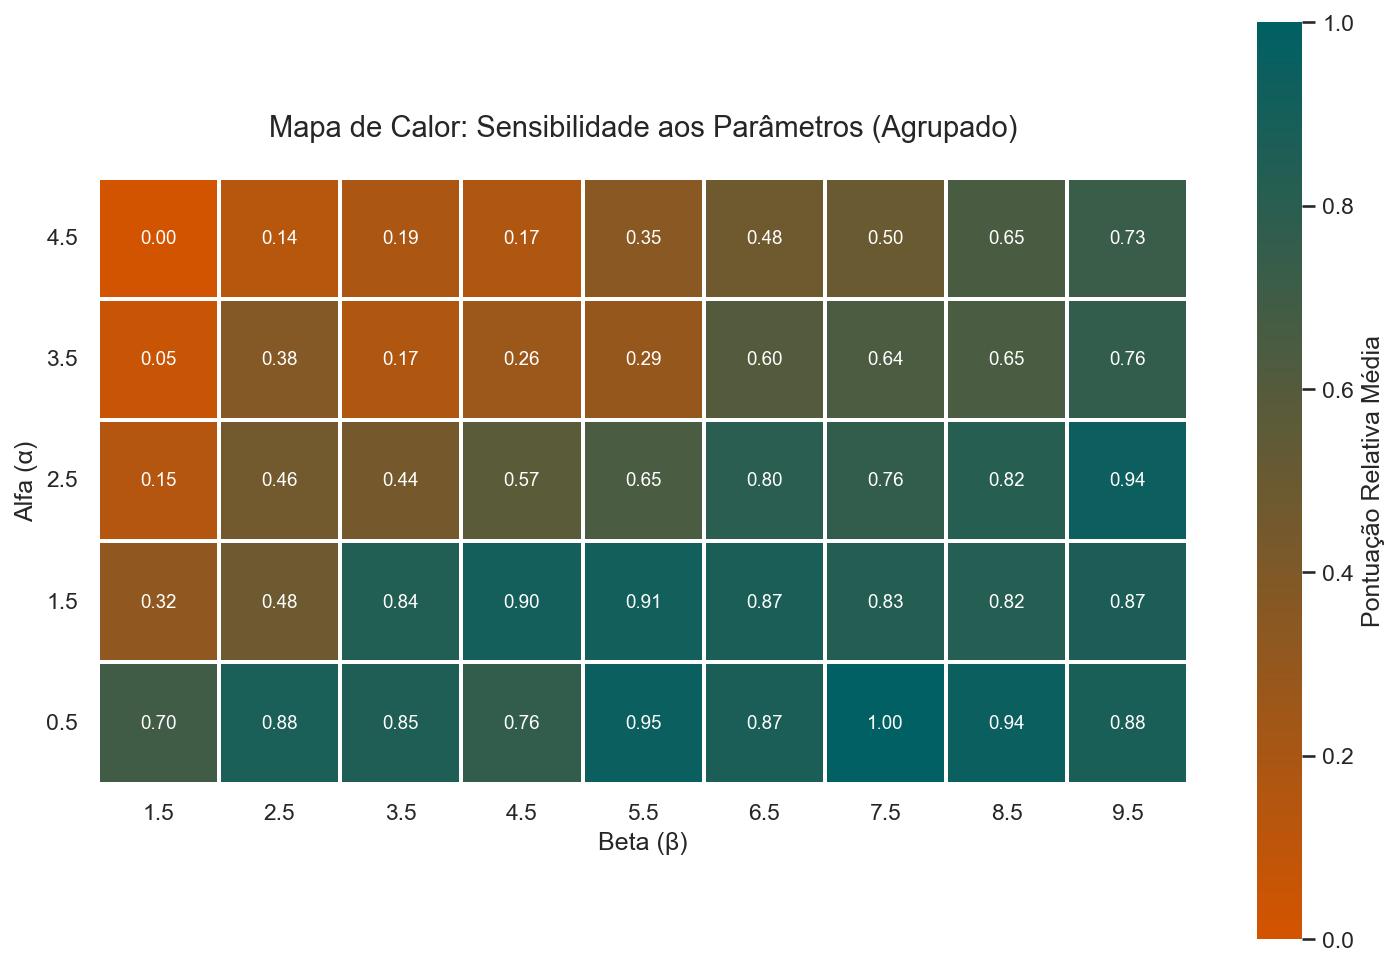

In [107]:
# --- 1. Preparação e Limpeza dos Dados (A Mágica acontece aqui) ---
df_hm = df_resumo[['alfa', 'beta', 'fit_max']].copy()

# Definindo 'bins' (intervalos) fixos para agrupar os dados espalhados
# Ajuste o 'step' para aumentar ou diminuir a resolução do gráfico
step_alfa = 1  # Agrupa alfas a cada 0.5
step_beta = 1.0  # Agrupa betas a cada 1.0

# Criação das caixinhas (bins)
df_hm['alfa_bin'] = pd.cut(df_hm['alfa'], 
                           bins=np.arange(0, df_hm['alfa'].max() + step_alfa, step_alfa))
df_hm['beta_bin'] = pd.cut(df_hm['beta'], 
                           bins=np.arange(0, df_hm['beta'].max() + step_beta, step_beta))

# Agrupamento real (Tirando a média dos pontos que caem no mesmo quadrado)
pivot_rel = df_hm.pivot_table(
    index='alfa_bin',
    columns='beta_bin',
    values='fit_max',
    aggfunc='mean' # Se tiver mais de um teste no mesmo bin, tira a média
)

# Ordenação (Invertendo o Y para o 0 ficar embaixo)
pivot_rel = pivot_rel.sort_index(ascending=False)

# --- 2. Formatação dos Rótulos (Para não ficar aquele texto feio de intervalo) ---
# Transforma "(0.5, 1.0]" em apenas "0.75" (centro) ou "1.0" (limite superior)
y_labels = [f"{i.mid:.1f}" for i in pivot_rel.index]
x_labels = [f"{c.mid:.1f}" for c in pivot_rel.columns]

# --- 3. Plotagem Visualmente Agradável ---
plt.figure(figsize=(10, 8), dpi=150)

# Máscara para pintar de cinza onde não tem dados (opcional, mas fica bonito)
mask = pivot_rel.isnull()

ax = sns.heatmap(
    pivot_rel,
    annot=True,           # Mostra os números
    fmt=".2f",            # Apenas 2 casas decimais
    annot_kws={"size": 9},# Tamanho da fonte dos números
    cmap=gradiente,        # Paleta Amarelo -> Laranja -> Vermelho
    mask=mask,            # Esconde células vazias
    linewidths=1,         # Linhas brancas mais grossas para separar
    linecolor='white',
    vmin=0, vmax=1.00, # Trava a escala de cores para destacar o topo
    cbar_kws={"label": "Pontuação Relativa Média", "shrink": 0.8},
    square=True           # Força quadrados perfeitos
)

# Ajuste dos eixos com os rótulos limpos criados acima
ax.set_yticklabels(y_labels, rotation=0)
ax.set_xticklabels(x_labels, rotation=0)

plt.title("Mapa de Calor: Sensibilidade aos Parâmetros (Agrupado)", fontsize=14, pad=20)
plt.ylabel("Alfa (α)", fontsize=12)
plt.xlabel("Beta (β)", fontsize=12)

# Cor de fundo para onde não tem dados (onde a máscara atuou)
ax.set_facecolor("#f0f0f0") 

plt.tight_layout()
plt.show()